# Probability Queue Position Models

## Overview

Here, we will demonstrate how queue position models affect order fill simulation and, ultimately, the strategy's performance. It is essential for accurate backtesting to find the proper queue position modeling by comparing backtest and real trading results. In this context, we will illustrate comparisons by changing queue position models. By doing this, you can determine the appropriate queue position model that aligns with the backtesting and real trading results.

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2023-04-04-01007356e6514df3811b0c80ab8c83bf">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [1]:
import numpy as np

from numba import njit, uint64
from numba.typed import Dict

from hftbacktest import (
    BacktestAsset,
    ROIVectorMarketDepthBacktest,
    GTX,
    LIMIT,
    BUY,
    SELL,
    BUY_EVENT,
    SELL_EVENT,
    Recorder
)
from hftbacktest.stats import LinearAssetRecord

@njit(cache=True)
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue
        
        # Sets the tick index to 0 for the nearest possible best price 
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth / .5) - 1
        
        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades) 
        # since the mid-price is measured in a previous time-step; 
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue
        
        # All of our possible quotes within the order arrival depth, 
        # excluding those at the same price, are considered executed.
        out[:tick] += 1
        
        max_tick = max(max_tick, tick)
    return out[:max_tick]

@njit(cache=True)
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept

@njit(cache=True)
def compute_coeff_simplified(gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = inv_k
    c2 = np.sqrt(np.divide(gamma * np.exp(1), 2 * A * delta * k))
    return c1, c2

@njit
def gridtrading_glft_mm(hbt, recorder, gamma, order_qty):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    
    arrival_depth = np.full(30_000_000, np.nan, np.float64)
    mid_price_chg = np.full(30_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    delta = 1
    
    grid_num = 20
    max_position = 50 * order_qty
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000_000) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for last_trade in hbt.last_trades(asset_no):
                trade_price_tick = last_trade.px / tick_size
                
                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = max(trade_price_tick - mid_price_tick, depth)
                else:
                    depth = max(mid_price_tick - trade_price_tick, depth)
            arrival_depth[t] = depth
        
        hbt.clear_last_trades(asset_no)
        hbt.clear_inactive_orders(asset_no)
        
        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)

        #--------------------------------------------------------
        # Computes bid price and ask price.
        
        c1, c2 = compute_coeff_simplified(gamma, delta, A, k)
        
        half_spread_tick = c1 + delta / 2 * c2 * volatility
        skew = c2 * volatility
        
        normalized_position = position / order_qty
        
        reservation_price_tick = mid_price_tick - skew * normalized_position

        bid_price_tick = min(np.round(reservation_price_tick - half_spread_tick), best_bid_tick)
        ask_price_tick = max(np.round(reservation_price_tick + half_spread_tick), best_ask_tick)
        
        bid_price = bid_price_tick * tick_size
        ask_price = ask_price_tick * tick_size

        grid_interval = max(np.round(half_spread_tick) * tick_size, tick_size)

        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        #--------------------------------------------------------
        # Records variables and stats for analysis.
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
        
        # Records the current state for stat calculation.
        recorder.record(hbt)

In [2]:
def backtest(args):
    asset_name, asset_info, model = args

    # Obtains the mid-price of the assset to determine the order quantity.
    snapshot = np.load('data/{}_20230730_eod.npz'.format(asset_name))['data']
    best_bid = max(snapshot[snapshot['ev'] & BUY_EVENT == BUY_EVENT]['px'])
    best_ask = min(snapshot[snapshot['ev'] & SELL_EVENT == SELL_EVENT]['px'])
    mid_price = (best_bid + best_ask) / 2.0

    latency_data = np.concatenate(
        [np.load('latency/live_order_latency_{}.npz'.format(date))['data'] for date in range(20230731, 20230732)]
    )

    asset = (
        BacktestAsset()
            .data(['data/{}_{}.npz'.format(asset_name, date) for date in range(20230731, 20230732)])
            .initial_snapshot('data/{}_20230730_eod.npz'.format(asset_name))
            .linear_asset(1.0) 
            .intp_order_latency(latency_data)
            .no_partial_fill_exchange()
            .trading_value_fee_model(-0.00005, 0.0007)
            .tick_size(asset_info['tick_size'])
            .lot_size(asset_info['lot_size'])
            .roi_lb(0.0)    
            .roi_ub(mid_price * 5)
            .last_trades_capacity(10000)
    )

    if model == 'SquareProbQueueModel':
        asset.power_prob_queue_model(2)
    elif model == 'LogProbQueueModel2':
        asset.log_prob_queue_model2()
    elif model == 'PowerProbQueueModel3':
        asset.power_prob_queue_model3(3)
    else:
        raise ValueError


    hbt = ROIVectorMarketDepthBacktest([asset])

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid_price) / asset_info['lot_size']), 1) * asset_info['lot_size']

    recorder = Recorder(1, 30_000_000)
    
    gamma = 0.00005
    gridtrading_glft_mm(hbt, recorder.recorder, gamma, order_qty)

    hbt.close()

    recorder.to_npz('stats/gridtrading_simple_glft_qm_{}_{}.npz'.format(model, asset_name))

In [3]:
%%capture
from multiprocessing import Pool
import json

with open('assets2.json', 'r') as f:
    assets = json.load(f)

with Pool(16) as p:
    print(p.map(backtest, [(k, v, 'SquareProbQueueModel') for k, v in assets.items()]))
    
with Pool(16) as p:
    print(p.map(backtest, [(k, v, 'LogProbQueueModel2') for k, v in assets.items()]))
    
with Pool(16) as p:
    print(p.map(backtest, [(k, v, 'PowerProbQueueModel3') for k, v in assets.items()]))

Text(0, 0.5, 'Cumulative Returns (%)')

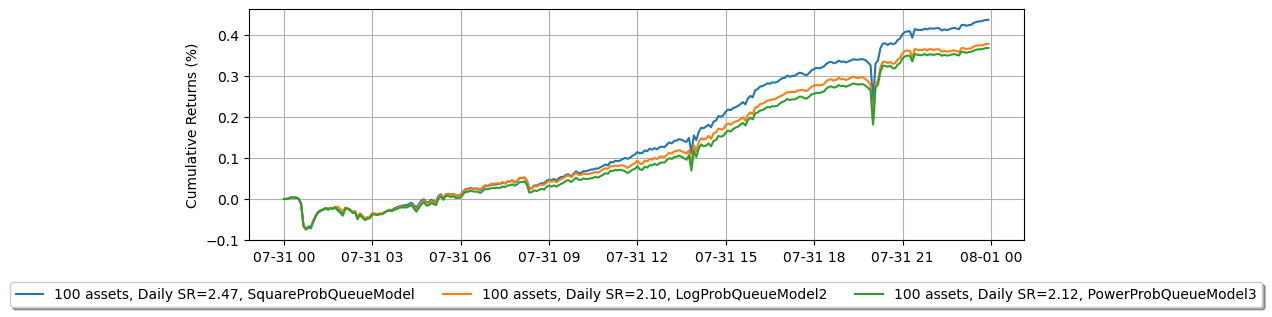

In [4]:
import polars as pl
from matplotlib import pyplot as plt

def compute_net_equity(model):
    equity_values = {}
    sr_values = {}

    for asset_name in assets.keys():
        data = np.load('stats/gridtrading_simple_glft_qm_{}_{}.npz'.format(model, asset_name))['0']
        stats = (
            LinearAssetRecord(data)
                .resample('5m')
                .stats()
        )
    
        equity = stats.entire.with_columns(
            (pl.col('equity_wo_fee') - pl.col('fee')).alias('equity')
        ).select(['timestamp', 'equity'])
    
        pnl = equity['equity'].diff()
        sr = np.divide(pnl.mean(), pnl.std())

        equity_values[asset_name] = equity
        sr_values[asset_name] = sr

    sr_m = np.nanmean(list(sr_values.values()))
    sr_s = np.nanstd(list(sr_values.values()))

    asset_number = 0
    net_equity = None
    for i, (equity, sr) in enumerate(zip(equity_values.values(), sr_values.values())):
        # There are some assets that aren't working within this scheme.
        # This might be because the order arrivals don't follow a Poisson distribution that this model assumes.
        # As a result, it filters out assets whose SR falls outside -0.5 sigma.
        if (sr - sr_m) / sr_s > -0.5:
            asset_number += 1
            if net_equity is None:
                net_equity = equity.clone()
            else:
                net_equity = net_equity.select(
                    'timestamp',
                    (pl.col('equity') + equity['equity']).alias('equity')
                )

            if asset_number == 100:
                # 5_000 is capital for each trading asset.
                return net_equity.with_columns(
                    (pl.col('equity') / asset_number / 5_000).alias('equity')
                )

np.seterr(divide='ignore', invalid='ignore')

fig = plt.figure()
fig.set_size_inches(10, 3)
legend = []

for model in ['SquareProbQueueModel', 'LogProbQueueModel2', 'PowerProbQueueModel3']:
    net_equity_ = compute_net_equity(model)

    pnl = net_equity_['equity'].diff()
    # Since the P&L is resampled at a 5-minute interval
    sr = pnl.mean() / pnl.std() * np.sqrt(24 * 60 / 5)
    legend.append('100 assets, Daily SR={:.2f}, {}'.format(sr, model))
    plt.plot(net_equity_['timestamp'], net_equity_['equity'] * 100)
    
plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')